In [1]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, length, lower, split, when,count, when, lit, unix_timestamp, to_date
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import avg

In [40]:
# !wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Industrial_and_Scientific.json.gz

In [ ]:
# !wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles2/meta_Industrial_and_Scientific.json.gz

In [2]:
!pip install textblob
!pip install pyspark nltk
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Data Reading

In [2]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("readGZ") \
    .master("local[*]") \
    .config("spark.default.parallelism", 24) \
    .config("spark.sql.shuffle.partitions", 24) \
    .getOrCreate()

/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/12/03 13:23:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:

# Read the gzipped JSON file directly into a DataFrame
df = spark.read.json("Industrial_and_Scientific.json.gz")

# Show the DataFrame to check if it's loaded correctly
#df.show(10)

23/12/03 13:23:45 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [7]:
### load the meta data

df_meta = spark.read.json("meta_Industrial_and_Scientific.json.gz")
#df_meta.show(10)

# EDA and Data Pre-Processing

In [8]:
# summarize the nulls in dataframe
# Create an expression for each column that counts its nulls
exprs = [count(when(col(c).isNull(), c)).alias(c) for c in df.columns]

# Compute all null counts in a single pass
null_counts = df.agg(*exprs).first().asDict()

# Get the total count of rows for percentage calculation
total_count = df.count()

# Iterate through the results and calculate percentages
for column, null_count in null_counts.items():
    null_percentage = (null_count / total_count) * 100
    print(f"Number of Nulls in {column}: {null_count}, Percentage: {null_percentage:.2f}%")


Number of Nulls in asin: 0, Percentage: 0.00%
Number of Nulls in image: 1725623, Percentage: 98.14%
Number of Nulls in overall: 0, Percentage: 0.00%
Number of Nulls in reviewText: 984, Percentage: 0.06%
Number of Nulls in reviewTime: 0, Percentage: 0.00%
Number of Nulls in reviewerID: 0, Percentage: 0.00%
Number of Nulls in reviewerName: 110, Percentage: 0.01%
Number of Nulls in style: 1066819, Percentage: 60.67%
Number of Nulls in summary: 403, Percentage: 0.02%
Number of Nulls in unixReviewTime: 0, Percentage: 0.00%
Number of Nulls in verified: 0, Percentage: 0.00%
Number of Nulls in vote: 1552025, Percentage: 88.27%


In [4]:
# Drop the image, style, vote columns
df = df.drop('image', 'style', 'vote')

In [5]:
# Handling missing values: For simplicity, we'll drop rows with any NULLs
df = df.na.drop()

# Filtering out unverified reviews
df = df.filter(col('verified') == True)

# Feature Engineering - creating a new feature for the length of the reviewText
df = df.withColumn('reviewText_length', length(col('reviewText')))


In [6]:
# Sample a fraction of the data (5%)
fraction = 0.05
seed = 42  # You can choose any number for the seed
df = df.sample(False, fraction, seed)

In [13]:
min_length, max_length = df.selectExpr("min(reviewText_length)", "max(reviewText_length)").first()

df.count()

81986

In [14]:
min_length,max_length

(1, 12541)

In [7]:
# Example of filtering based on a condition, such as reviews that are too short/long might be outliers
df = df.filter(col('reviewText_length') > 10)  # Example threshold
df = df.filter(col('reviewText_length') < 1000)  # Example threshold

In [16]:
df.count()

75582

In [17]:
# Find the range for 'reviewText_length'
min_length, max_length = df.selectExpr("min(reviewText_length)", "max(reviewText_length)").first()

min_length,max_length

(11, 999)

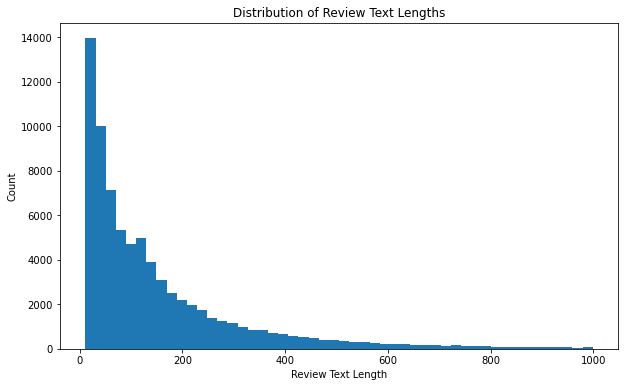

In [18]:
# Number of bins for the histogram
num_bins = 50

# Compute the bin size
bin_size = (max_length - min_length) / num_bins

# Create bins and count the number of records in each bin
bins_expr = [
    ((col('reviewText_length') - min_length) / bin_size).cast('integer').alias('bin')
]
histogram_df = df.select(*bins_expr).groupBy('bin').count()

# Collect the histogram data
histogram_data = histogram_df.sort('bin').collect()

# Prepare data for plotting
bins = [min_length + bin_size * i for i in range(num_bins + 1)]
counts = [0] * num_bins
for row in histogram_data:
    counts[row['bin']] = row['count']

plt.figure(figsize=(10, 6))
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.title('Distribution of Review Text Lengths')
plt.xlabel('Review Text Length')
plt.ylabel('Count')
plt.grid(False)
plt.show()


## Text Processing

In [20]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline
from pyspark.sql.functions import lower, col
import nltk

# Ensure required NLTK resources are downloaded
nltk.download('vader_lexicon')

# Text Preprocessing Pipeline
tokenizer = Tokenizer(inputCol='reviewText', outputCol='reviewText_tokens')
remover = StopWordsRemover(inputCol='reviewText_tokens', outputCol='reviewText_clean')
preprocessing_pipeline = Pipeline(stages=[tokenizer, remover])

# Transform DataFrame
df = df.withColumn('reviewText', lower(col('reviewText')))
df = preprocessing_pipeline.fit(df).transform(df)

# Define and register UDF for sentiment analysis (batch processing not shown here)
# Batch processing would require a more complex setup, possibly using Pandas UDFs
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, FloatType
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def analyze_sentiment(review_text):
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(review_text)['compound']

sentiment_analysis_udf = udf(analyze_sentiment, FloatType())
df = df.withColumn("sentiment_score", sentiment_analysis_udf(df["reviewText"]))


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ynx9zm/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [21]:
# Split reviewTime into day, month, and year
split_col = split(df['reviewTime'], ' ')
df = df.withColumn('Day', split_col.getItem(0))
df = df.withColumn('Month', split_col.getItem(1).substr(0,2))
df = df.withColumn('Year', split_col.getItem(2))
df = df.drop('reviewTime')

# Data Visulization

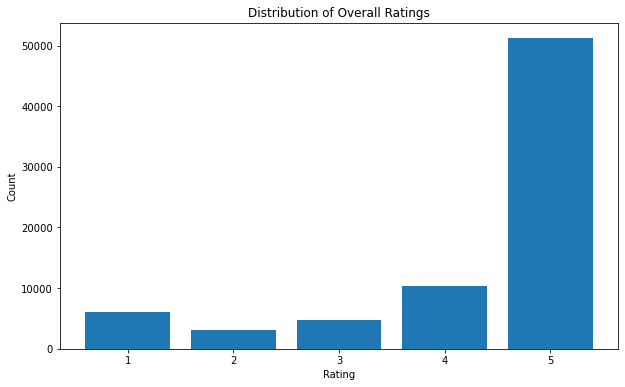

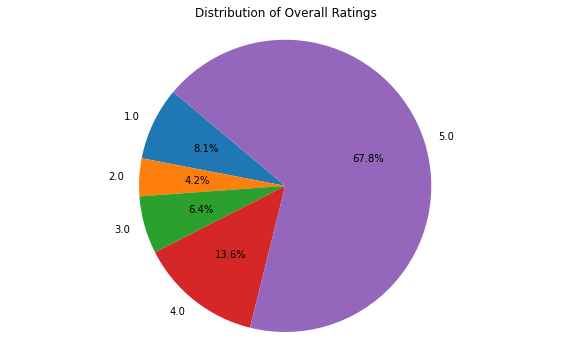

In [22]:


# Average rating (no change needed here)
average_rating = df.agg(avg("overall")).first()[0]

# Count of reviews for each asin (no change needed here)
reviews_per_asin = df.groupBy("asin").agg(count("reviewerID").alias("Number_of_Reviews"))

# Count of reviews for each reviewer (no change needed here)
reviews_per_reviewers = df.groupBy("reviewerID").agg(count("asin").alias("Number_of_Reviews"))

# Histogram for overall ratings - Compute in PySpark
overall_rating_distribution = df.groupBy("overall").count().orderBy("overall").collect()

# Convert histogram data to Pandas DataFrame for plotting
pdf_histogram = pd.DataFrame(overall_rating_distribution, columns=['Rating', 'Count'])

# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(pdf_histogram['Rating'], pdf_histogram['Count'])
plt.title('Distribution of Overall Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(False)
plt.show()

# Pie chart for overall ratings - Compute in PySpark
rating_counts = df.groupBy("overall").count().orderBy("overall").collect()

# Convert pie chart data to Pandas Series for plotting
pdf_pie = pd.Series({row['overall']: row['count'] for row in rating_counts})

# Plot pie chart
plt.figure(figsize=(10, 6))
plt.pie(pdf_pie, labels=pdf_pie.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Overall Ratings')
plt.axis('equal')
plt.show()

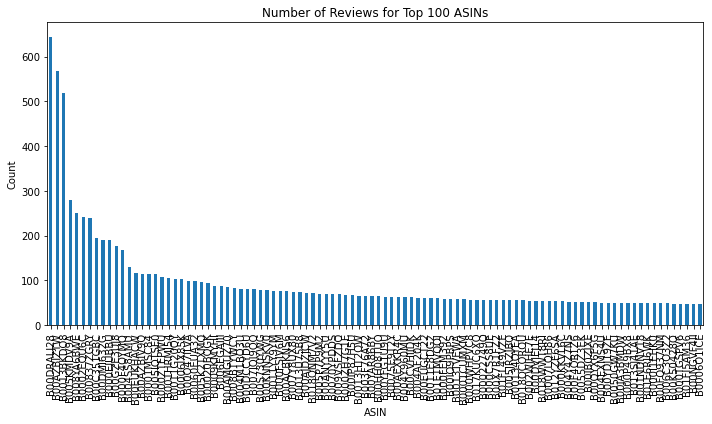

In [23]:
# Bar chart for number of reviews for each asin
# Sort and get top 100 ASINs in PySpark
top_reviews_per_asin = reviews_per_asin.orderBy(col("Number_of_Reviews").desc()).limit(100)

# Convert to Pandas DataFrame for plotting
top_reviews_per_asin_pdf = top_reviews_per_asin.toPandas()

# Plot bar chart using Pandas
plt.figure(figsize=(10, 6))
top_reviews_per_asin_pdf.set_index('asin')['Number_of_Reviews'].plot(kind='bar', legend=False)
plt.title('Number of Reviews for Top 100 ASINs')
plt.ylabel('Count')
plt.xlabel('ASIN')
plt.grid(False)
plt.tight_layout()
plt.show()

In [8]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable


In [25]:
from pyspark.sql.functions import concat_ws, collect_list
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# # Sample a fraction of the data (5%)
# fraction = 0.01
# seed = 42  # You can choose any number for the seed
# sampled_df = df.sample(False, fraction, seed)

# Concatenate reviewText from all rows in the sampled PySpark DataFrame
review_text_str = df.select(concat_ws(" ", collect_list("reviewText"))).first()[0]

# Concatenate summary from all rows in the sampled PySpark DataFrame
summary_str = df.select(concat_ws(" ", collect_list("summary"))).first()[0]

# Generate word clouds
generate_word_cloud(review_text_str, "Word Cloud for Review Text")
generate_word_cloud(summary_str, "Word Cloud for Summary")

ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
plot = False

In [ ]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import pandas as pd
if plot:
    # Define the number of bins for the histogram
    num_bins = 20

    # Calculate the range for sentiment scores
    min_score, max_score = df.selectExpr("min(sentiment_score)", "max(sentiment_score)").first()

    # Compute the bin size
    bin_size = (max_score - min_score) / num_bins

    # Create bins and count the number of records in each bin
    bins_expr = [
        ((col('sentiment_score') - min_score) / bin_size).cast('integer').alias('bin')
    ]
    histogram_df = df.select(*bins_expr).groupBy('bin').count()

    # Collect the histogram data
    histogram_data = histogram_df.sort('bin').collect()

    # Prepare data for plotting
    bins = [min_score + bin_size * i for i in range(num_bins + 1)]
    counts = [0] * num_bins
    for row in histogram_data:
        if 0 <= row['bin'] < num_bins:
            counts[row['bin']] = row['count']

    # Plotting using Matplotlib
    plt.figure(figsize=(10, 6))
    plt.hist(bins[:-1], bins=bins, weights=counts)
    plt.title('Distribution of Sentiment Scores')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Count')
    plt.grid(False)
    plt.show()

# Modelling

## Data Splitting

In [ ]:
###sampling
# sampled_df = df.sample(fraction=0.01, seed=42)
# sampled_df.count()

In [9]:
from pyspark.ml.feature import StringIndexer

# Indexing is required to convert string identifiers to numeric indices for the ALS algorithm
indexer_user = StringIndexer(inputCol="reviewerID", outputCol="userIndex")
df = indexer_user.fit(df).transform(df)

indexer_item = StringIndexer(inputCol="asin", outputCol="itemIndex")
df = indexer_item.fit(df).transform(df)

In [10]:
(train, test) = df.randomSplit([0.8, 0.2],seed = 42)

In [11]:
train = train.select("userIndex","itemIndex","overall")
test = test.select("userIndex","itemIndex","overall")


## ALS

refer: https://www.kaggle.com/code/nadianizam/h-m-fashion-recommendation-with-pyspark



In [12]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Setting up the ALS model; In this model set the cold start as drop
als = ALS(maxIter=5, regParam=0.01, userCol="userIndex", itemCol="itemIndex", ratingCol="overall", coldStartStrategy="drop")

In [20]:
# Fit the ALS model to the training data
model = als.fit(train)

23/12/03 13:27:15 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:27:23 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:27:31 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:27:32 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:27:33 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:33 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:34 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:34 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:35 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:27:36 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:36 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:27:37 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:38 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:27:39 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:39 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:27:40 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:40 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:27:41 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


In [21]:
# # Fitting the ALS model on the training data
# model = als.fit(train)

# Predicting on the train and test sets
predictions_train = model.transform(train)
predictions_test = model.transform(test)

# Create an RMSE evaluator using the label and predicted columns
reg_evaluator = RegressionEvaluator(metricName="rmse", labelCol="overall", predictionCol="prediction")

# Evaluate the model on training data
rmse_train = reg_evaluator.evaluate(predictions_train)

# Evaluate the model on test data
rmse_test = reg_evaluator.evaluate(predictions_test)

23/12/03 13:27:42 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:42 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:42 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:27:51 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:27:52 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:52 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:52 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:28:01 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


In [22]:
model_path = "models/RatingALSModel_1.obj"
# Save the model, overwriting any existing model at the specified path
model.write().overwrite().save(model_path)

23/12/03 13:28:01 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
23/12/03 13:28:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
23/12/03 13:28:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
23/12/03 13:28:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers


23/12/03 13:28:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
23/12/03 13:28:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
23/12/03 13:28:02 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
23/12/03 13:28:03 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
23/12/03 13:28:03 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
23/12/03 13:28:03 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
23/12/03 13:28:03 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.4

## For user who first appear in test set, recommend the most popular stuff to them.

In [51]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Create a Spark session
spark = SparkSession.builder.appName("PopularItemsRecommendation").getOrCreate()

# Find users in the test set that do not appear in the train set
newUsers = test.select("userIndex").subtract(train.select("userIndex")).distinct()

# Calculate item popularity based on the train set
itemPopularity = train.groupBy("itemIndex").agg(F.count("overall").alias("popularity"))

# Rank items based on popularity in descending order
rankedItems = itemPopularity.orderBy(F.desc("popularity"))

# Join the new users with the ranked items to recommend the most popular items
recommendations = newUsers.crossJoin(rankedItems.limit(10))  # Replace k with the number of items to recommend

# Select relevant columns for further processing or output
newRecommendations = recommendations.groupBy("userIndex").agg(F.collect_list("itemIndex").alias("name"))

In [14]:
newRecommendations.count()

23/12/03 13:25:50 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:25:50 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:25:59 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:25:59 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:26:07 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


14457

In [15]:
test.count()

23/12/03 13:26:07 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


15311

# grid search for ALS model

In [43]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [10,30]) \
    .addGrid(als.maxIter, [5, 15]) \
    .addGrid(als.regParam, [0.01, 1.0]) \
    .build()


##cross validation
cross_val = CrossValidator(
    estimator=als,
    estimatorParamMaps=param_grid,
    evaluator=reg_evaluator,
    numFolds=5)

In [17]:
retrain = False
if retrain:
    cv_model = cross_val.fit(train)
# best_model = cv_model.bestModel

# # Specify the path where you want to save the model
# model_path = "models/Best_RatingALSModel.obj"

# # Save the model, overwriting any existing model at the specified path
# best_model.write().overwrite().save(model_path)

In [49]:
rmse_train

0.003260037985302759

In [50]:
rmse_test

4.940007887749806

In [51]:
cv_model.avgMetrics

[4.950013332730643,
 4.603276629442055,
 4.806474429015735,
 4.582132936875243,
 4.610608182697979,
 4.522620926823878,
 4.565218829699182,
 4.505357481791878]

## Recall

In [18]:
from pyspark.ml.recommendation import ALSModel
recommendnum = 10
als_model = ALSModel.load("models/Best_RatingALSModel.obj")
als_model.recommendForAllUsers(recommendnum).show(1)

+---------+--------------------+
|userIndex|     recommendations|
+---------+--------------------+
|        3|[{3017, 4.086563}...|
+---------+--------------------+
only showing top 1 row



In [23]:
als_model0 = ALSModel.load("models/RatingALSModel_1.obj")
als_model0.recommendForAllUsers(recommendnum).show(1)

+---------+--------------------+
|userIndex|     recommendations|
+---------+--------------------+
|        3|[{1610, 20.023806...|
+---------+--------------------+
only showing top 1 row



In [24]:
df_temp = als_model.recommendForAllUsers(10) # Only on training set

In [25]:
df_temp0 = als_model0.recommendForAllUsers(10) # Only on training set

In [24]:
# x = df_temp.select('recommendations').collect()
# x0 = df_temp0.select('recommendations').collect()

In [26]:
df_temp.groupBy(col("userIndex")).count().count()

58708

In [92]:
df_temp0.orderBy(col("userIndex"))

587220

In [27]:
from pyspark.sql.functions import col,explode
df_temp = df_temp.withColumn("name", explode(col('recommendations')))

In [28]:
df_temp0 = df_temp0.withColumn("name", explode(col('recommendations')))

In [29]:
df_temp.show(10)

+---------+--------------------+------------------+
|userIndex|     recommendations|              name|
+---------+--------------------+------------------+
|        3|[{3017, 4.086563}...|  {3017, 4.086563}|
|        3|[{3017, 4.086563}...| {10471, 4.073551}|
|        3|[{3017, 4.086563}...|{19573, 4.0489764}|
|        3|[{3017, 4.086563}...|{22730, 3.8789766}|
|        3|[{3017, 4.086563}...|  {448, 3.8419113}|
|        3|[{3017, 4.086563}...|  {655, 3.7570543}|
|        3|[{3017, 4.086563}...|  {296, 3.7474897}|
|        3|[{3017, 4.086563}...|{26095, 3.4820004}|
|        3|[{3017, 4.086563}...| {2915, 3.3522973}|
|        3|[{3017, 4.086563}...|{15945, 3.1983292}|
+---------+--------------------+------------------+
only showing top 10 rows



In [31]:
from pyspark.sql.functions import col,expr
df_temp = df_temp.withColumn("name", expr("transform(recommendations, r -> r.itemIndex)"))
df_temp = df_temp.drop_duplicates()
df_temp0 = df_temp0.withColumn("name", expr("transform(recommendations, r -> r.itemIndex)"))
df_temp0 = df_temp0.drop_duplicates()

In [52]:
# Ensure the column order is the same in both DataFrames
df_temp = df_temp.select("userIndex", "name")
df_temp0 = df_temp0.select("userIndex", "name")

# Union the DataFrames
best_pred = df_temp.unionByName(newRecommendations)
base_pred = df_temp0.unionByName(newRecommendations)

In [33]:
from pyspark.sql.functions import collect_list
actualitem = test.groupby('userIndex').agg(collect_list('itemIndex').alias('indexlist')) # This should be test

In [34]:
actualitem.orderBy(col("userIndex")).show(10)

23/12/03 13:30:15 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:30:23 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
+---------+--------------------+
|userIndex|           indexlist|
+---------+--------------------+
|      0.0|   [7992.0, 19998.0]|
|      2.0|[4351.0, 17086.0,...|
|      3.0|      [296.0, 276.0]|
|      4.0|    [11723.0, 493.0]|
|      5.0|     [101.0, 1871.0]|
|      6.0|     [5001.0, 722.0]|
|      8.0|           [13923.0]|
|      9.0|           [14645.0]|
|     10.0|            [5159.0]|
|     12.0|            [7699.0]|
+---------+--------------------+
only showing top 10 rows



In [35]:
actualitem.count()-newRecommendations.count()

23/12/03 13:30:57 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:31:06 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:31:06 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:31:06 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:31:15 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:31:15 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:31:24 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


734

In [36]:
result = df_temp.join(actualitem, 'userIndex')

In [37]:
result.count()

23/12/03 13:31:24 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:31:33 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:31:34 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


734

In [38]:
result0 = df_temp0.join(actualitem, 'userIndex')

In [39]:
result0.count()

23/12/03 13:31:35 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:31:44 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:31:44 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


734

In [53]:
result_best = best_pred.join(actualitem, 'userIndex')

In [54]:
result_base = base_pred.join(actualitem, 'userIndex')

In [40]:
from pyspark.sql.functions import array_intersect, size, avg
metrics = result.withColumn('TP', size(array_intersect(col('name'),col('indexlist')))) \
                .withColumn('precision', col('TP')/recommendnum) \
                .withColumn('recall', col('TP')/size(col('indexlist'))) \
                .withColumn('F1', when((col('precision') + col('recall')) >0,
                                        2* (col('precision') *col('recall'))/(col('precision') +col('recall')))
                             .otherwise(0))

In [41]:
metrics0 = result0.withColumn('TP', size(array_intersect(col('name'),col('indexlist')))) \
                .withColumn('precision', col('TP')/recommendnum) \
                .withColumn('recall', col('TP')/size(col('indexlist'))) \
                .withColumn('F1', when((col('precision') + col('recall')) >0,
                                        2* (col('precision') *col('recall'))/(col('precision') +col('recall')))
                             .otherwise(0))

In [55]:
metrics_best = result_best.withColumn('TP', size(array_intersect(col('name'),col('indexlist')))) \
                .withColumn('precision', col('TP')/recommendnum) \
                .withColumn('recall', col('TP')/size(col('indexlist'))) \
                .withColumn('F1', when((col('precision') + col('recall')) >0,
                                        2* (col('precision') *col('recall'))/(col('precision') +col('recall')))
                             .otherwise(0))

In [56]:
metrics_base = result_base.withColumn('TP', size(array_intersect(col('name'),col('indexlist')))) \
                .withColumn('precision', col('TP')/recommendnum) \
                .withColumn('recall', col('TP')/size(col('indexlist'))) \
                .withColumn('F1', when((col('precision') + col('recall')) >0,
                                        2* (col('precision') *col('recall'))/(col('precision') +col('recall')))
                             .otherwise(0))

In [42]:
from pyspark.sql.functions import max as ma
from pyspark.sql.functions import avg
# Result of the grid searched ALS model
average_metrics = metrics.agg(
    avg(col('precision')),
    avg(col('recall')),
    avg(col('F1'))
)
average_metrics.show()

23/12/03 13:31:59 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:32:10 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:32:10 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


+--------------------+--------------------+-------------------+
|      avg(precision)|         avg(recall)|            avg(F1)|
+--------------------+--------------------+-------------------+
|0.005449591280653951|0.052452316076294275|0.00984642060936339|
+--------------------+--------------------+-------------------+



In [43]:
# result of an original ALS model
average_metrics0 = metrics0.agg(
    avg(col('precision')),
    avg(col('recall')),
    avg(col('F1'))
)
average_metrics0.show()

23/12/03 13:32:11 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:32:21 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:32:21 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


+--------------------+--------------------+--------------------+
|      avg(precision)|         avg(recall)|             avg(F1)|
+--------------------+--------------------+--------------------+
|0.001362397820163...|0.013623978201634877|0.002477086945751...|
+--------------------+--------------------+--------------------+



In [57]:
average_metrics_best = metrics_best.agg(
    avg(col('precision')),
    avg(col('recall')),
    avg(col('F1'))
)

23/12/03 13:39:51 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:40:01 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:40:01 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
+--------------------+--------------------+-------------------+
|      avg(precision)|         avg(recall)|            avg(F1)|
+--------------------+--------------------+-------------------+
|0.005449591280653951|0.052452316076294275|0.00984642060936339|
+--------------------+--------------------+-------------------+



In [58]:
average_metrics_best.show()

23/12/03 13:40:09 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:40:09 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:40:09 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:40:20 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:40:20 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:40:20 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:40:28 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


+--------------------+------------------+--------------------+
|      avg(precision)|       avg(recall)|             avg(F1)|
+--------------------+------------------+--------------------+
|0.004482917516950...|0.0444890615057161|0.008139941159492216|
+--------------------+------------------+--------------------+



In [59]:
average_metrics_base = metrics_base.agg(
    avg(col('precision')),
    avg(col('recall')),
    avg(col('F1'))
)
average_metrics_base.show()

23/12/03 13:40:30 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:40:30 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:40:30 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:40:40 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:40:40 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:40:40 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:40:49 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
+--------------------+-------------------+--------------------+
|      avg(precision)|        avg(recall)|             avg(F1)|
+--------------------+-------------------+--------------------+
|0.004285432163781...|0.04261295065060452|0.007783869083322715|
+--------------------+-------------------+--------------------+



# Data Reading

In [2]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("readGZ") \
    .master("local[*]") \
    .config("spark.default.parallelism", 24) \
    .config("spark.sql.shuffle.partitions", 24) \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .getOrCreate()

# Read the gzipped JSON file directly into a DataFrame
df = spark.read.json("Industrial_and_Scientific.json.gz")

/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/12/02 18:52:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/02 18:52:27 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


23/12/02 18:52:38 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [3]:
# Show the DataFrame to check if it's loaded correctly
df.show(10)

+----------+-----+-------+--------------------+-----------+--------------+----------------+-----+--------------------+--------------+--------+----+
|      asin|image|overall|          reviewText| reviewTime|    reviewerID|    reviewerName|style|             summary|unixReviewTime|verified|vote|
+----------+-----+-------+--------------------+-----------+--------------+----------------+-----+--------------------+--------------+--------+----+
|0176496920| null|    5.0|Arrived on time, ...|01 23, 2013|A3FANY5GOT5X0W|    Kelly Keyser| null|  Just as described!|    1358899200|    true|null|
|0176496920| null|    5.0|This device was h...| 11 5, 2012| AT6HRPPYOPHMB|       Michael C| null|        Great device|    1352073600|    true|null|
|0176496920| null|    4.0|Just a clicker no...|10 17, 2012| A4IX7B38LIN1E|              BH| null|         Pretty Good|    1350432000|    true|null|
|0176496920| null|    5.0|Great response ca...|03 29, 2017|A12Q4LR8N17AOZ|   Waterfall3500| null|Thank you for t

In [4]:
df.select("overall").summary("count").show()

+-------+-------+
|summary|overall|
+-------+-------+
|  count|1758333|
+-------+-------+



In [5]:
df_meta.select("asin").summary("count").show()

NameError: name 'df_meta' is not defined

In [ ]:
### load the meta data
df_meta = spark.read.json("meta_Industrial_and_Scientific.json.gz")

In [ ]:
df_meta.show(10)

+--------------------+--------------------+----------+--------------------+--------------------+-----------------+--------------------+-------+--------------------+---+--------------------+--------------------+--------------------+------+--------------------+------------+--------------------+-----+--------------------+
|            also_buy|           also_view|      asin|               brand|            category|             date|         description|details|             feature|fit|            imageURL|     imageURLHighRes|            main_cat| price|                rank|similar_item|               tech1|tech2|               title|
+--------------------+--------------------+----------+--------------------+--------------------+-----------------+--------------------+-------+--------------------+---+--------------------+--------------------+--------------------+------+--------------------+------------+--------------------+-----+--------------------+
|[1454894547, 0133...|               

## Discussion



1.   We can not read some categories (especially those with large data, in this case, the sofrware category) directly in Spark; Need to figure out why and how to solve this. (Tried reading by in raw and use pandas and then spark, but this also failed.)
(I skipped this question by choosing another category which is fine to read directly)





# Data Pre-Processing and visulization

In [7]:
# Drop the image column because I don't think we need it
df = df.drop('image')

In [8]:
from pyspark.sql.functions import col, when, length, unix_timestamp, to_date

# Handling missing values: For simplicity, we'll drop rows with any NULLs
df = df.na.drop()

# Filtering out unverified reviews
df = df.filter(col('verified') == True)

# Feature Engineering - creating a new feature for the length of the reviewText
df = df.withColumn('reviewText_length', length(col('reviewText')))


In [ ]:
# Show the processed DataFrame
df.show(10)

+----------+-------+--------------------+-----------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+
|      asin|overall|          reviewText| reviewTime|    reviewerID| reviewerName|               style|             summary|unixReviewTime|verified|vote|reviewText_length|
+----------+-------+--------------------+-----------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+
|1587790637|    5.0|I love everything...| 08 3, 2014| ALORN8T3UJC88| Ji Sung Moon|{null, null, null...|Great studying ma...|    1407024000|    true|   6|              390|
|1587790637|    2.0|Disappointed with...| 06 9, 2014|A2DR04A9BINUE6|        Becky|{null, null, null...|             Creased|    1402272000|    true|   4|              157|
|1587790637|    1.0|Very poor packagi...| 04 8, 2014|A39NP41GNG6DJT|  Nicole Ryan|{null, null, null...|Poster bent and w...|    1396915200| 

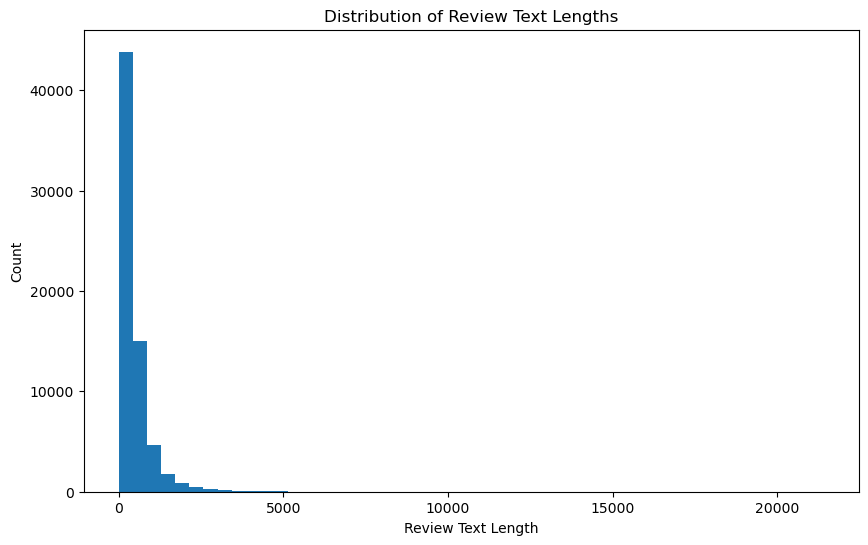

In [ ]:
import matplotlib.pyplot as plt

review_lengths = df.select('reviewText_length').rdd.flatMap(lambda x: x).collect()

# Now convert this list to a Pandas Series
pd_series = pd.Series(review_lengths)

# Plotting the distribution of reviewText_length using Pandas/Matplotlib
plt.figure(figsize=(10, 6))
pd_series.hist(bins=50)  # Adjust the number of bins for your specific dataset
plt.title('Distribution of Review Text Lengths')
plt.xlabel('Review Text Length')
plt.ylabel('Count')
plt.grid(False)
plt.show()

In [9]:
# Example of filtering based on a condition, such as reviews that are too short/long might be outliers
df = df.filter(col('reviewText_length') > 10)  # Example threshold

df = df.filter(col('reviewText_length') < 1000)  # Example threshold

In [ ]:
# Text Processing - cleaning the review text, tokenizing, and removing stop words (simplified example)
from pyspark.ml.feature import Tokenizer, StopWordsRemover
tokenizer = Tokenizer(inputCol='reviewText', outputCol='reviewText_tokens')
df = tokenizer.transform(df)
remover = StopWordsRemover(inputCol='reviewText_tokens', outputCol='reviewText_clean')
df = remover.transform(df)

In [ ]:
# Show the processed DataFrame
df.show(10)

+----------+-------+--------------------+-----------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+--------------------+--------------------+
|      asin|overall|          reviewText| reviewTime|    reviewerID| reviewerName|               style|             summary|unixReviewTime|verified|vote|reviewText_length|   reviewText_tokens|    reviewText_clean|
+----------+-------+--------------------+-----------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+--------------------+--------------------+
|1587790637|    5.0|I love everything...| 08 3, 2014| ALORN8T3UJC88| Ji Sung Moon|{null, null, null...|Great studying ma...|    1407024000|    true|   6|              390|[i, love, everyth...|[love, everything...|
|1587790637|    2.0|Disappointed with...| 06 9, 2014|A2DR04A9BINUE6|        Becky|{null, null, null...|             Creased|    1402272000|    t

In [ ]:
from pyspark.sql.functions import when, col, length, split

# Split reviewTime into day, month, and year
split_col = split(df['reviewTime'], ' ')
df = df.withColumn('Day', split_col.getItem(0))
df = df.withColumn('Month', split_col.getItem(1).substr(0,2))
df = df.withColumn('Year', split_col.getItem(2))
df = df.drop('reviewTime')

# Convert 'vote' to integer type
df = df.withColumn('vote', df['vote'].cast('int'))

In [ ]:
df.show(10)

+----------+-------+--------------------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+--------------------+--------------------+---+-----+----+
|      asin|overall|          reviewText|    reviewerID| reviewerName|               style|             summary|unixReviewTime|verified|vote|reviewText_length|   reviewText_tokens|    reviewText_clean|Day|Month|Year|
+----------+-------+--------------------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+--------------------+--------------------+---+-----+----+
|1587790637|    5.0|I love everything...| ALORN8T3UJC88| Ji Sung Moon|{null, null, null...|Great studying ma...|    1407024000|    true|   6|              390|[i, love, everyth...|[love, everything...| 08|   3,|2014|
|1587790637|    2.0|Disappointed with...|A2DR04A9BINUE6|        Becky|{null, null, null...|             Creased|    1402272000|    t

In [ ]:
df.select('reviewerName').distinct().count()

44622

In [ ]:
df.select('asin').distinct().count()

7425

In [ ]:
from pyspark.sql.functions import avg, count

# Average rating
average_rating = df.agg(avg("overall")).first()[0]

# Count of reviews for each asin
reviews_per_asin = df.groupBy("asin").agg(count("reviewerID").alias("Number_of_Reviews"))

# Summary for vote column
votes_summary = df.describe(['vote'])



In [ ]:
# Count of reviews for each reviewer
reviews_per_reviewers = df.groupBy("reviewerID").agg(count("asin").alias("Number_of_Reviews"))

In [ ]:
votes_summary

In [ ]:


# Convert Spark DataFrame to Pandas for Visualization
pdf = df.toPandas()
reviews_per_asin_pdf = reviews_per_asin.toPandas()

# Histogram for overall ratings
plt.figure(figsize=(10, 6))
pdf['overall'].hist()
plt.title('Distribution of Overall Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(False)
plt.show()

# Plotting the pie chart for overall ratings
rating_counts = pdf['overall'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Overall Ratings')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()




In [ ]:

# Bar chart for number of reviews for each asin
top_reviews_per_asin_pdf = reviews_per_asin_pdf.sort_values(by='Number_of_Reviews', ascending=False).head(100)
plt.figure(figsize=(10, 6))
# Set the 'asin' as the index and plot the 'review_count' column
top_reviews_per_asin_pdf.set_index('asin')['Number_of_Reviews'].plot(kind='bar', legend=False)
plt.title('Number of Reviews for Top 100 ASINs')
plt.ylabel('Count')
plt.xlabel('ASIN')
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# Bar chart for number of reviews for each reviewers
reviews_per_reviewers_pdf = reviews_per_reviewers.toPandas()

top_reviews_per_reviewers_pdf = reviews_per_reviewers_pdf.sort_values(by='Number_of_Reviews', ascending=False).head(100)
plt.figure(figsize=(10, 6))
# Set the 'reviewers' as the index and plot the 'review_count' column
top_reviews_per_reviewers_pdf.set_index('reviewerID')['Number_of_Reviews'].plot(kind='bar', legend=False)
plt.title('Number of Reviews for Top 100 reviewers')
plt.ylabel('Count')
plt.xlabel('reviewers')
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# Convert reviewText and summary columns to a single string
review_text_str = ' '.join(df.rdd.map(lambda row: row.reviewText).collect())
summary_str = ' '.join(df.rdd.map(lambda row: row.summary).collect())

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_word_cloud(review_text_str, "Word Cloud for Review Text")
generate_word_cloud(summary_str, "Word Cloud for Summary")


# Data Splitting

In [10]:
## Data Splitting
from pyspark.ml.feature import StringIndexer

# Indexing is required to convert string identifiers to numeric indices for the ALS algorithm
indexer_user = StringIndexer(inputCol="reviewerID", outputCol="userIndex")
df = indexer_user.fit(df).transform(df)

indexer_item = StringIndexer(inputCol="asin", outputCol="itemIndex")
df = indexer_item.fit(df).transform(df)
# Add seed 1
(train, test) = df.randomSplit([0.8, 0.2],1)

## ALS (collabortaive filtering)
refer: https://www.kaggle.com/code/nadianizam/h-m-fashion-recommendation-with-pyspark

In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Setting up the ALS model
als = ALS(maxIter=5, regParam=0.01, userCol="userIndex", itemCol="itemIndex", ratingCol="overall", coldStartStrategy="drop")

# Fitting the ALS model on the training data
model = als.fit(train)

# Predicting on the train and test sets
predictions_train = model.transform(train)
predictions_test = model.transform(test)

# Create an RMSE evaluator using the label and predicted columns
reg_evaluator = RegressionEvaluator(metricName="rmse", labelCol="overall", predictionCol="prediction")

# Evaluate the model on training data
rmse_train = reg_evaluator.evaluate(predictions_train)

# Evaluate the model on test data
rmse_test = reg_evaluator.evaluate(predictions_test)


In [ ]:
rmse_train

In [ ]:
rmse_test

# GNN

In [11]:
!pip install torch torchvision
!pip install torch-geometric

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [27]:
# Standard library imports
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree
from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import pandas as pd

In [28]:
# columns = ["overall","itemIndex","userIndex"]
# train = train.select(columns)
# test = test.select(columns)
# train_df = train.toPandas()
# test_df = test.toPandas()
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')

In [30]:
torch_geometric.__version__

'2.3.1'

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [32]:
print("Train Size  : ", len(train_df))
print("Test Size : ", len (test_df))

Train Size  :  60271
Test Size :  15311


In [7]:
# Since we performed the train/test randomly on the interactions, not all users and items may be present in the training set. We will relabel all of users and items to ensure the highest label is the number of users and items, respectively.

In [33]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_df['user_id_idx'] = le_user.fit_transform(train_df['userIndex'].values)
train_df['item_id_idx'] = le_item.fit_transform(train_df['itemIndex'].values)

In [34]:
train_user_ids = train_df['userIndex'].unique()
train_item_ids = train_df['itemIndex'].unique()

print(len(train_user_ids), len(train_item_ids))

test_df = test_df[
  (test_df['userIndex'].isin(train_user_ids)) & \
  (test_df['itemIndex'].isin(train_item_ids))
]
# test_df['user_known'] = test_df['userIndex'].isin(train_user_ids)
# test_df['item_known'] = test_df['itemIndex'].isin(train_item_ids)

print(len(test_df))

58708 24087
522


In [35]:
test_df['user_id_idx'] = le_user.transform(test_df['userIndex'].values)
test_df['item_id_idx'] = le_item.transform(test_df['itemIndex'].values)

In [36]:
n_users = train_df['user_id_idx'].nunique()
n_items = train_df['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  58708
Number of unique Items :  24087


In [37]:
def data_loader(data, batch_size, n_usr, n_itm):

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    indices = [x for x in range(n_usr)]

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device), 
        torch.LongTensor(list(pos_items)).to(device) + n_usr, 
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )
data_loader(train_df, 16, n_users, n_items)

(tensor([ 5191,  9278, 11405, 17647, 17702, 18916, 22824, 24990, 25206, 33577,
         36128, 39064, 40954, 44933, 49826, 56445], device='cuda:0'),
 tensor([70924, 59189, 71918, 58819, 60536, 59132, 75638, 69717, 67676, 67030,
         65938, 58861, 60269, 58735, 58712, 63829], device='cuda:0'),
 tensor([77740, 59078, 72402, 65003, 59907, 78806, 78498, 73348, 69124, 82495,
         79102, 69173, 77099, 60242, 60524, 75913], device='cuda:0'))

In [38]:
train_df.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

,user_id_idx,item_id_idx
0,0,"[1645, 14747, 4698, 7457, 8298, 2300]"
1,1,"[684, 1728, 1291, 416, 20597, 21203, 22286]"
2,2,"[2490, 1671, 8044, 19305]"
3,3,"[655, 3017, 296, 17412, 448]"
4,4,"[10853, 10877, 18058, 20950]"
...,...,...
58703,58703,[9349]
58704,58704,[24040]
58705,58705,[719]
58706,58706,[12939]


In [39]:
u_t = torch.LongTensor(train_df.user_id_idx)
i_t = torch.LongTensor(train_df.item_id_idx) + n_users

train_edge_index = torch.stack((
  torch.cat([u_t, i_t]),
  torch.cat([i_t, u_t])
)).to(device)
train_edge_index

tensor([[57916, 51104, 53451,  ..., 82794, 68193, 68193],
        [68194, 62582, 62582,  ..., 33296, 13204, 39068]], device='cuda:0')

In [40]:
class LightGCNConv(MessagePassing):
    def __init__(self, **kwargs):
        super().__init__(aggr='add')

    def forward(self, x, edge_index):
    # Compute normalization
        from_, to_ = edge_index
        deg = degree(to_, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

        # Start propagating messages (no update after aggregation)
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

In [41]:
import numpy as np
test_x = torch.Tensor(np.eye(5))
test_edge_index = torch.LongTensor(np.array([
  [0, 0, 1, 1, 2, 3, 3, 4],
  [2, 3, 3, 4, 0, 0, 1, 1]
]))

LightGCNConv()(test_x, test_edge_index)

tensor([[0.0000, 0.0000, 0.7071, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.7071],
        [0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7071, 0.0000, 0.0000, 0.0000]])

In [42]:
class RecSysGNN(nn.Module):
  def __init__(
      self,
      latent_dim,
      num_layers,
      num_users,
      num_items,
      model, # 'NGCF' or 'LightGCN'
      dropout=0.1 # Only used in NGCF
  ):
    super(RecSysGNN, self).__init__()

    assert (model == 'NGCF' or model == 'LightGCN'), \
        'Model must be NGCF or LightGCN'
    self.model = model
    self.embedding = nn.Embedding(num_users + num_items, latent_dim)

    self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

    self.init_parameters()


  def init_parameters(self):
    if self.model == 'NGCF':
      nn.init.xavier_uniform_(self.embedding.weight, gain=1)
    else:
      # Authors of LightGCN report higher results with normal initialization
      nn.init.normal_(self.embedding.weight, std=0.1)


  def forward(self, edge_index):
    emb0 = self.embedding.weight
    embs = [emb0]

    emb = emb0
    for conv in self.convs:
      emb = conv(x=emb, edge_index=edge_index)
      embs.append(emb)

    out = (
      torch.cat(embs, dim=-1) if self.model == 'NGCF'
      else torch.mean(torch.stack(embs, dim=0), dim=0)
    )

    return emb0, out


  def encode_minibatch(self, users, pos_items, neg_items, edge_index):
    emb0, out = self(edge_index)
    return (
        out[users],
        out[pos_items],
        out[neg_items],
        emb0[users],
        emb0[pos_items],
        emb0[neg_items]
    )

In [43]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
  # compute loss from initial embeddings, used for regulization
  reg_loss = (1 / 2) * (
    user_emb0.norm().pow(2) +
    pos_emb0.norm().pow(2)  +
    neg_emb0.norm().pow(2)
  ) / float(len(users))

  # compute BPR loss from user, positive item, and negative item embeddings
  pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
  neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

  bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

  return bpr_loss, reg_loss

In [44]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K = 10):
  test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())
  # compute the score of all user-item pairs
  relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

  # create dense tensor of all user-item interactions
  i = torch.stack((
    torch.LongTensor(train_df['user_id_idx'].values),
    torch.LongTensor(train_df['item_id_idx'].values)
  ))
  v = torch.ones((len(train_df)), dtype=torch.float64)
  interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\
      .to_dense().to(device)

  # mask out training user-item interactions from metric computation
  relevance_score = torch.mul(relevance_score, (1 - interactions_t))

  # compute top scoring items for each user
  topk_relevance_indices = torch.topk(relevance_score, K).indices
  topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
  topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
  topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
  topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

  # measure overlap between recommended (top-scoring) and held-out user-item
  # interactions
  test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
  metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
  metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]

  metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1)
  metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)
  # Compute F1-score
  metrics_df['f1_score'] = 2 * (metrics_df['precision'] * metrics_df['recall']) / (metrics_df['precision'] + metrics_df['recall'])
  metrics_df['f1_score'] = metrics_df['f1_score'].fillna(0)  # Handling undefined F1-score when precision and recall are both 0


  return metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['f1_score'].mean()

In [45]:
latent_dim = 64
n_layers = 3

EPOCHS = 20
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005
K = 10

In [46]:
def train_and_eval(model, optimizer, train_df):
  loss_list_epoch = []
  bpr_loss_list_epoch = []
  reg_loss_list_epoch = []

  recall_list = []
  precision_list = []
  f1_list = []

  for epoch in tqdm(range(EPOCHS)):
      n_batch = int(len(train_df)/BATCH_SIZE)

      final_loss_list = []
      bpr_loss_list = []
      reg_loss_list = []

      model.train()
      for batch_idx in range(n_batch):

          optimizer.zero_grad()

          users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
          users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

          bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
          )
          reg_loss = DECAY * reg_loss
          final_loss = bpr_loss + reg_loss

          final_loss.backward()
          optimizer.step()

          final_loss_list.append(final_loss.item())
          bpr_loss_list.append(bpr_loss.item())
          reg_loss_list.append(reg_loss.item())

      model.eval()
      with torch.no_grad():
          _, out = model(train_edge_index)
          final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
          test_topK_recall,  test_topK_precision,test_topK_f1 = get_metrics(
            final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K
          )

      loss_list_epoch.append(round(np.mean(final_loss_list),4))
      bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
      reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

      recall_list.append(round(test_topK_recall,4))
      precision_list.append(round(test_topK_precision,4))
      f1_list.append(round(test_topK_f1,4))

  return (
    loss_list_epoch,
    bpr_loss_list_epoch,
    reg_loss_list_epoch,
    recall_list,
    precision_list,
    f1_list
  )

In [47]:
lightgcn = RecSysGNN(
  latent_dim=latent_dim,
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items,
  model='LightGCN'
)

lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([82795, 64])]


In [48]:
light_loss, light_bpr, light_reg, light_recall, light_precision,light_f1 = train_and_eval(lightgcn, optimizer, train_df)

  0%|          | 0/20 [00:00<?, ?it/s]

In [54]:
torch.save(lightgcn.state_dict(), 'lightgcn_model.pth')

In [58]:
# Initialize the model again with the same parameters
loaded_model = RecSysGNN(
    latent_dim=latent_dim,
    num_layers=n_layers,
    num_users=n_users,
    num_items=n_items,
    model='LightGCN'
)

# Load the state dict
loaded_model.load_state_dict(torch.load('lightgcn_model.pth'))

# Don't forget to call .to(device) if you are using a GPU
loaded_model.to(device)


RecSysGNN(
  (embedding): Embedding(82795, 64)
  (convs): ModuleList(
    (0-2): 3 x LightGCNConv()
  )
)

In [59]:
def evaluate_model(model, train_df, test_df, n_users, n_items, train_edge_index, K):
    model.eval()
    with torch.no_grad():
        _, out = model(train_edge_index)
        final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
        test_topK_recall, test_topK_precision, test_topK_f1 = get_metrics(
            final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K
        )

    return test_topK_recall, test_topK_precision, test_topK_f1
# Assume model is already loaded and other necessary variables (like train_df, test_df) are set
test_topK_recall, test_topK_precision, test_topK_f1 = evaluate_model(
    loaded_model, train_df, test_df, n_users, n_items, train_edge_index, K
)


In [60]:
test_topK_recall, test_topK_precision, test_topK_f1

(0.013944223107569721, 0.001394422310756972, 0.002535313292285404)

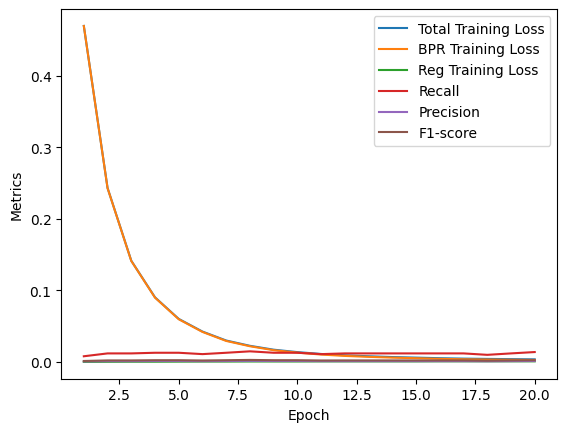

In [49]:
from matplotlib import pyplot as plt
epoch_list = [(i+1) for i in range(EPOCHS)]
plt.plot(epoch_list, light_loss, label='Total Training Loss')
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')
plt.plot(epoch_list, light_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')
plt.plot(epoch_list, light_f1, label='F1-score')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

In [50]:
np.average(light_precision),np.average(light_recall),np.average(light_f1)

(0.0012499999999999998, 0.012065000000000003, 0.0022550000000000005)

# Content-based Filtering

In [4]:
df_meta = spark.read.json("meta_Industrial_and_Scientific.json.gz")

In [17]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import expr,col,when
from pyspark.sql import functions as F
from pyspark.sql.functions import mean
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import Normalizer
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import numpy as np
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, length, lower, split, when,count, when, lit, unix_timestamp, to_date
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import avg

In [18]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("readGZ") \
    .master("local[*]") \
    .config("spark.default.parallelism", 24) \
    .config("spark.sql.shuffle.partitions", 24) \
    .getOrCreate()

In [19]:

# Read the gzipped JSON file directly into a DataFrame
df = spark.read.json("Industrial_and_Scientific.json.gz")


In [20]:
# Drop the image, style, vote columns
df = df.drop('image', 'style', 'vote')
# Handling missing values: For simplicity, we'll drop rows with any NULLs
df = df.na.drop()

# Filtering out unverified reviews
df = df.filter(col('verified') == True)

# Feature Engineering - creating a new feature for the length of the reviewText
df = df.withColumn('reviewText_length', length(col('reviewText')))

# Sample a fraction of the data (5%)
fraction = 0.05
seed = 42  # You can choose any number for the seed
df = df.sample(False, fraction, seed)

# Example of filtering based on a condition, such as reviews that are too short/long might be outliers
df = df.filter(col('reviewText_length') > 10)  # Example threshold
df = df.filter(col('reviewText_length') < 1000)  # Example threshold


from pyspark.ml.feature import StringIndexer

# Indexing is required to convert string identifiers to numeric indices for the ALS algorithm
indexer_user = StringIndexer(inputCol="reviewerID", outputCol="userIndex")
df = indexer_user.fit(df).transform(df)

indexer_item = StringIndexer(inputCol="asin", outputCol="itemIndex")
df = indexer_item.fit(df).transform(df)

(train, test) = df.randomSplit([0.8, 0.2],seed = 42)

In [14]:
# Step 1: The item profiles are already in 'df_transformed' as 'features'

from pyspark.sql.functions import avg, count, collect_list
from pyspark.sql.window import Window

# Replace null or empty strings with a placeholder
df_meta = df_meta.na.fill({"brand": "Unknown"})
df_meta = df_meta.withColumn("brand", F.when(F.col("brand") == "", "Unknown").otherwise(F.col("brand")))

# Step 1: Remove the dollar sign and try to convert the price to float
df_meta = df_meta.withColumn("price", regexp_replace(col("price"), "[\$,]", "").cast("float"))

# Step 2: Replace non-numeric (or negative) values with None, which Spark recognizes as null
df_meta = df_meta.withColumn("price", when(col("price") < 0, None).otherwise(col("price")))

# Step 3: Calculate the average of the numeric prices
average_price = df_meta.select(avg(col("price")).alias("avg_price")).collect()[0]["avg_price"]

# Step 4: Fill null values with the average price
df_meta = df_meta.na.fill({"price": average_price})


# Ensure the 'brand' column exists and does not have empty strings or null values
if 'brand' not in df_meta.columns:
    raise ValueError("'brand' column is missing from the DataFrame.")
if df_meta.filter((col('brand') == "") | (col('brand').isNull())).count() > 0:
    raise ValueError("'brand' column contains null or empty strings.")

# Ensure the 'price' column exists and has the correct data type
if 'price' not in df_meta.columns:
    raise ValueError("'price' column is missing from the DataFrame.")
if df_meta.filter(col('price').isNull()).count() > 0:
    df_meta = df_meta.fillna({'price': 0})  # Replace nulls with 0 in 'price' column

In [15]:
df_meta.select('brand').distinct().count()

24124

In [16]:
df_meta.groupBy('brand').count().orderBy(col('count').desc()).show()

+--------------------+-----+
|               brand|count|
+--------------------+-----+
|              uxcell| 7147|
|         Small Parts| 4252|
|   The Hillman Group| 1868|
|             Unknown| 1742|
|           SmartSign| 1164|
|                  3M| 1021|
|                 VXB| 1003|
|               Brady|  866|
|     ComplianceSigns|  793|
|Hard-to-Find Fast...|  700|
|                SEOH|  680|
|   RAW PRODUCTS CORP|  660|
|           Fastenere|  608|
|             Generic|  582|
|              Vestil|  573|
|      D&D PowerDrive|  568|
|             Medline|  560|
|  Simpson Strong-Tie|  492|
|               EISCO|  487|
|             Hillman|  458|
+--------------------+-----+
only showing top 20 rows



In [21]:
# Assuming 'train' and 'test' are the DataFrames resulting from splitting 'df',
# and 'df_meta' is the DataFrame containing the metadata

# Select the 'asin' from train and test DataFrames
train_asin = train.select('asin').distinct()
test_asin = test.select('asin').distinct()

# Join the metadata with the asin DataFrames to filter the rows
df_train = df_meta.join(train_asin, on='asin', how='inner')
df_test = df_meta.join(test_asin, on='asin', how='inner')

# Now df_train_meta and df_test_meta contain metadata for asins in the train and test sets respectively

In [22]:
# Convert the 'price' column into a vector column
assembler_for_price = VectorAssembler(inputCols=["price"], outputCol="price_vector")

# Normalize the price column
price_scaler = MinMaxScaler(inputCol="price_vector", outputCol="price_scaled")

# Define the pipeline with all the stages
pipeline = Pipeline(stages=[
    # brand_indexer,
    # brand_encoder,
    assembler_for_price,
    price_scaler
    # assembler_for_features
])

# After cleaning, try fitting the pipeline again
pipeline_model = pipeline.fit(df_train)

# Now transform the data
df_transformed = pipeline_model.transform(df_train)

# Show the result
df_transformed.show()

23/12/02 19:02:37 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:02:44 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:02:45 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:02:47 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:02:48 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:02:56 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


+----------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+---+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|      asin|            also_buy|           also_view|               brand|            category|             date|         description|             details|             feature|fit|            imageURL|     imageURLHighRes|            main_cat|   price|                rank|        similar_item|               tech1|tech2|               title|        price_vector|        price_scaled|
+----------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+---+--------------------+--------------------+-----

In [23]:
df_transformed.select('price','price_scaled').show(10)

23/12/02 19:03:02 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:03:10 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
+--------+--------------------+
|   price|        price_scaled|
+--------+--------------------+
|   23.61|[3.52999652819054...|
|   23.84|[3.56439896736742...|
|59.06999|[8.83396390199366...|
|59.06999|[8.83396390199366...|
|59.06999|[8.83396390199366...|
|59.06999|[8.83396390199366...|
|    27.0|[4.03705948439507...|
|   52.95|[7.91855991785994...|
|   19.19|[2.86887006546799...|
|   29.99|[4.48429204957595...|
+--------+--------------------+
only showing top 10 rows



In [24]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from pyspark.ml.linalg import Vectors, VectorUDT
# UDF to extract the first element of a vector column
first_element_udf = udf(lambda vector: float(vector[0]), FloatType())

df_transformed = df_transformed.withColumn("price_scaled_float", first_element_udf("price_scaled"))

In [25]:
df_transformed.select('price','price_scaled_float').show(10)

23/12/02 19:03:14 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:03:22 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:03:23 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


+--------+------------------+
|   price|price_scaled_float|
+--------+------------------+
|   23.61|      3.5299966E-4|
|   23.84|       3.564399E-4|
|59.06999|      8.8339637E-4|
|59.06999|      8.8339637E-4|
|59.06999|      8.8339637E-4|
|59.06999|      8.8339637E-4|
|    27.0|      4.0370596E-4|
|   52.95|        7.91856E-4|
|   19.19|        2.86887E-4|
|   29.99|       4.484292E-4|
+--------+------------------+
only showing top 10 rows



In [26]:
from pyspark.sql.window import Window
from pyspark.sql.functions import avg, count, col, broadcast

df_train = df_transformed

# Use scaled priced instead

# Prepare the item profiles from the training set
item_profiles_train = df_train.select('asin', 'brand', 'price_scaled_float').distinct()

# Calculate the average price for each user in the training set
avg_price_train = train.join(df_train, 'asin').groupBy('reviewerID').agg(avg('price_scaled_float').alias('avg_price'))

# Count the occurrences of each brand for each user in the training set and find the most frequent one
brand_frequency_train = train.join(df_train, 'asin').groupBy('reviewerID', 'brand').agg(count('brand').alias('brand_count'))

# Find the top brand for each user in the training set
windowSpec = Window.partitionBy('reviewerID').orderBy(col('brand_count').desc(), col('brand'))
top_brands_train = (brand_frequency_train.withColumn('rank', F.row_number().over(windowSpec))
                    .where(col('rank') == 1)
                    .select('reviewerID', 'brand'))

# Create the user profiles using the training set
user_profiles_train = avg_price_train.join(broadcast(top_brands_train), 'reviewerID')

user_profiles_train.show(10)

23/12/02 19:03:24 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:03:24 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:03:33 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:03:33 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:03:33 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:03:36 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:03:36 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:03:36 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
+--------------+--------------------+--------------------+
|    reviewerID|           avg_price|               brand|
+--------------+--------------------+--------------------+
|A32T3VMP09YVWO|7.918559713289142E-4|      Craft / Empura|
| AHF0WHZARKT86|8.833963656798005E-4|                 DAP|
|A3B1KK88EVW8CJ|3.072293669295807...|            Shop-Vac|
| AMRVMZGBHT7Z6|8.833963656798005E-4|         Porta-Nails|
|A35AJ3CCYV3I61|1.817349839257076...|              DEWALT|
|A2FTLYHRE1DLUI|1.817349839257076...|              DEWALT|
|A3SE1RMKAZWSOM|8.331389835802838E-5|General Tools Mfg...|
| AK3T4XPTHWP0W|0.001542279380373...|               Scott|
| A2SFEYYXPFQ5H|8.929694740800187E-5|              Dremel|
|A1O5ICD3DW52SR|1.118829313782043...|              Dremel|
+--------------+--------------------+--------------------+
only showing top 10 rows



In [27]:
item_profiles_train.show(10)

23/12/02 19:03:37 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:03:45 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:03:45 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:03:48 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
+----------+--------------------+------------------+
|      asin|               brand|price_scaled_float|
+----------+--------------------+------------------+
|B00004WLKL|      Gardner Bender|      2.2346672E-4|
|B00004Y693|        Lord & Hodge|       7.927534E-5|
|B00004YOAO|         Irwin Tools|       7.777959E-5|
|B00004YSW8|       Warp Brothers|      8.8339637E-4|
|B00004Z0YY|   National Hardware|      1.4927697E-4|
|B000052030|M-D Building Prod...|      8.8339637E-4|
|B0000DD1F9|             Steelex|      8.8339637E-4|
|B0000DD4IB|             Grizzly|      8.8339637E-4|
|B0000DD5H0|                Kreg|      5.9232145E-5|
|B00018ABP0|     Apex Tool Group|       3.220374E-4|
+----------+--------------------+------------------+
only showing top 10 rows



In [28]:
from pyspark.sql import Window
from pyspark.sql.functions import rank, col

# Assuming calculate_similarity can be replaced with a native Spark function or combination of functions
def calculate_similarity(user_brand, user_avg_price, item_brand, item_price):
    # Simple similarity based on brand matching and price difference
    brand_similarity = 1 if user_brand == item_brand else 0
    # Prevent division by zero if user_avg_price is 0
    price_similarity = 1 - abs(item_price - user_avg_price) / user_avg_price if user_avg_price != 0 else 0
    # Combine the two components of similarity
    return brand_similarity * 0.5 + price_similarity * 0.5

# Register the UDF
similarity_udf = F.udf(calculate_similarity, FloatType())

# Generate recommendations for users in the validation set
# First, get the list of items each user has reviewed in the training set to exclude them from recommendations
df_already_reviewed_train = train.select('reviewerID', 'asin').distinct().alias("ar_train")

# Calculate similarities between user profiles and item profiles, excluding already reviewed items
user_profiles_val = test.select('reviewerID').distinct().alias("up_val")
item_profiles_alias = item_profiles_train.alias("ip")

user_profiles_val = user_profiles_val.join(broadcast(user_profiles_train), "reviewerID", "inner")
user_profiles_val = user_profiles_val.alias("up_val")
user_item_similarity = (user_profiles_val
                        .crossJoin(broadcast(item_profiles_alias))
                        .withColumn('similarity', similarity_udf(
                            col('up_val.brand'), col('up_val.avg_price'), col('ip.brand'), col('ip.price_scaled_float')))
                        .select('up_val.reviewerID', 'ip.asin', 'similarity'))

# Exclude already reviewed items
recommendations = user_item_similarity.join(broadcast(df_already_reviewed_train),
                                            (user_item_similarity.reviewerID == df_already_reviewed_train.reviewerID) &
                                            (user_item_similarity.asin == df_already_reviewed_train.asin),
                                            'left_anti')

# Use window functions to rank by similarity
windowSpec = Window.partitionBy(recommendations['reviewerID']).orderBy(recommendations['similarity'].desc())

ranked_recommendations = recommendations.withColumn("rank", rank().over(windowSpec))

# Get top N recommendations
top_recommendations = ranked_recommendations.filter(col("rank") <= 10)  # Replace N with the number of recommendations you want


In [29]:
top_recommendations.show(10)

23/12/02 19:03:49 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:03:49 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:03:49 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:03:49 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:03:58 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:03:58 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:03:58 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:03:58 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:03:58 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:04:01 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:04:01 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:04:01 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:04:02 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:04:02 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


23/12/02 19:04:32 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
+--------------+----------+----------+----+
|    reviewerID|      asin|similarity|rank|
+--------------+----------+----------+----+
|A1240X5POMJ6IJ|B00GU2GT2U|       1.0|   1|
|A1240X5POMJ6IJ|B00GU2NS56|       1.0|   1|
|A1240X5POMJ6IJ|B00GU2NOCS|       1.0|   1|
|A1240X5POMJ6IJ|B00F9MMUTS|       1.0|   1|
|A1240X5POMJ6IJ|B00FG7BR22|       1.0|   1|
|A1240X5POMJ6IJ|B00ITZOQEY|       1.0|   1|
|A1240X5POMJ6IJ|B00FG7C0GE|       1.0|   1|
|A1240X5POMJ6IJ|B00GU2GZWO|       1.0|   1|
|A1240X5POMJ6IJ|B00GU2G6T6|       1.0|   1|
|A1240X5POMJ6IJ|B00FG7BQIM|       1.0|   1|
+--------------+----------+----------+----+
only showing top 10 rows



In [30]:
from pyspark.sql.functions import collect_list

# Assuming top_recommendations DataFrame has columns 'reviewerID' and 'asin'
final_recommendations = (top_recommendations
                         .groupBy('reviewerID')
                         .agg(collect_list('asin').alias('recommendations')))


In [31]:
final_recommendations.show(1,truncate = False)

23/12/02 19:04:33 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:04:33 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:04:33 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:04:33 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:04:42 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:04:42 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:04:42 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:04:42 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:04:42 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:04:45 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:04:45 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:04:46 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:04:46 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:04:46 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


23/12/02 19:05:17 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


+--------------+------------------------------------------------------------------------------------------------------------------------------------+
|reviewerID    |recommendations                                                                                                                     |
+--------------+------------------------------------------------------------------------------------------------------------------------------------+
|A1240X5POMJ6IJ|[B00GU2GT2U, B00GU2NS56, B00GU2NOCS, B00F9MMUTS, B00FG7BR22, B00ITZOQEY, B00FG7C0GE, B00GU2GZWO, B00GU2G6T6, B00FG7BQIM, B00ITZOMSE]|
+--------------+------------------------------------------------------------------------------------------------------------------------------------+
only showing top 1 row



In [33]:
from pyspark.sql.functions import col, size, array_intersect

# Step 1: For each `reviewerID` in `test`, collect all `asin` values into a list.
actual_items = test.groupBy('reviewerID').agg(collect_list('asin').alias('actual_asin'))

# Join the actual items with the recommended items on `reviewerID`
results = final_recommendations.join(actual_items, 'reviewerID')

# Step 3: Calculate true positives, precision, recall, and F1 score.
metrics = results.withColumn('true_positives', size(array_intersect(col('recommendations'), col('actual_asin')))) \
                 .withColumn('precision', col('true_positives') / size(col('recommendations'))) \
                 .withColumn('recall', col('true_positives') / size(col('actual_asin'))) \
                 .withColumn('F1', when((col('precision') + col('recall')) > 0,
                                         2 * (col('precision') * col('recall')) / (col('precision') + col('recall')))
                             .otherwise(0))

# Show the results
metrics.select('reviewerID', 'precision', 'recall', 'F1').show()

23/12/02 19:07:43 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:07:43 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:07:43 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:07:43 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:07:43 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:07:52 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:07:52 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:07:53 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:07:53 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:07:53 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:07:53 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:07:55 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:07:56 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:07:56 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:07:56 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:07:56 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


23/12/02 19:08:27 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


+--------------+--------------------+------+-------------------+
|    reviewerID|           precision|recall|                 F1|
+--------------+--------------------+------+-------------------+
|A1240X5POMJ6IJ|                 0.0|   0.0|                0.0|
|A19G7YUR3HKOAR|                 0.0|   0.0|                0.0|
|A1DH81B19ASE30|                 0.0|   0.0|                0.0|
|A1HAW4JVUTSFFF|                 0.0|   0.0|                0.0|
|A1HCV0VRVP5ISS|                 0.0|   0.0|                0.0|
|A1HEXO1SF2YRTT|                 0.0|   0.0|                0.0|
|A1JS6UMCBBYKNU|                 0.0|   0.0|                0.0|
|A1OK9NMJH25J5Y|                 0.0|   0.0|                0.0|
|A1S7CNTU8FORM6|                 0.0|   0.0|                0.0|
|A1SRMG16HF5TLD|                 0.0|   0.0|                0.0|
|A1XPB58WAREZLT|                 0.0|   0.0|                0.0|
|A23XU2KM06GE1P|0.037037037037037035|   1.0|0.07142857142857142|
|A27IYRA843Q5EJ|         

In [34]:
from pyspark.sql.functions import avg
average_metrics = metrics.agg(
    avg(col('precision')).alias('avg_precision'),
    avg(col('recall')).alias('avg_recall'),
    avg(col('F1')).alias('avg_F1')
)
average_metrics.show()

23/12/02 19:08:28 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:08:28 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:08:28 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:08:28 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:08:28 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:08:37 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:08:37 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:08:37 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:08:37 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:08:37 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:08:38 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:08:40 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:08:40 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/02 19:08:41 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:08:41 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/02 19:08:41 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


23/12/02 19:09:11 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


+--------------------+-------------------+--------------------+
|       avg_precision|         avg_recall|              avg_F1|
+--------------------+-------------------+--------------------+
|0.002069261480609...|0.04234972677595628|0.003808041696468...|
+--------------------+-------------------+--------------------+

